## Exploratory Data Analysis

In [18]:
import numpy as np
import pandas as pd
from pathlib import Path

import datetime

import scipy.stats as stats

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# creating Path object for current working directory
cwd = Path('./')
root_dir = cwd.resolve().parent
# creating Path object for additional data directory
additional_data_dir = root_dir / 'additional_data'
# create new directory for additional data
Path(additional_data_dir).mkdir(exist_ok=True)

# creating Path object for plots directory
plots_dir = root_dir / 'plots'
# create new directory for plots directory
Path(plots_dir).mkdir(exist_ok=True)

# defining the directory to original data
data_dir = Path(root_dir / 'data')

# list the .csv files for the project
for file in data_dir.glob('*.csv'):
    print(file)
    
# reading in .csv files to dataframes
vehicles = pd.read_csv(data_dir / 'vehicles2019.csv', dtype={'Accident_Index': str})
casualties = pd.read_csv(data_dir / 'casualties2019.csv', dtype={'Accident_Index': str})
# cleaned accidents DataFrame
accidents = pd.read_pickle(additional_data_dir / 'accidents_cleaned.pkl')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents.head(5)

/home/jake/Documents/TrafficAccidents/data/vehicles2019.csv
/home/jake/Documents/TrafficAccidents/data/accidents2019.csv
/home/jake/Documents/TrafficAccidents/data/casualties2019.csv


,accident_index,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_(district),local_authority_(highway),...,lsoa_of_accident_location,district,converted_date,converted_time,sunrise,sunset,day_length,datetime,decimal_time,day_of_year
0,2019010152270,-0.127949,51.436208,1,3,2,1,3,9,E09000022,...,E01003117,lambeth,2019-01-15,21:45:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 21:45:00,21.750000,15
1,2019010157567,-0.123427,51.449310,1,3,2,2,3,9,E09000022,...,E01003023,lambeth,2019-01-15,08:42:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 08:42:00,8.700000,15
2,2019010157732,-0.145106,51.461256,1,2,1,2,3,9,E09000022,...,E01003026,lambeth,2019-01-15,07:08:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 07:08:00,7.133333,15
3,2019010157896,-0.240823,51.533125,1,3,2,1,3,28,E09000005,...,E01000535,brent,2019-01-15,21:05:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 21:05:00,21.083333,15
4,2019010157795,0.161736,51.550272,1,3,1,1,3,16,E09000002,...,E01000035,barking and dagenham,2019-01-15,16:10:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 16:10:00,16.166667,15


['00:00:00', '03:00:00', '06:00:00', '09:00:00', '12:00:00', '15:00:00', '18:00:00', '21:00:00', '00:00:00']


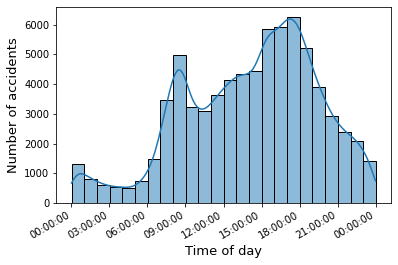

In [29]:
time_of_day = sns.histplot(data=accidents,
             x='decimal_time',
             binwidth=1,
             kde=True,
             stat='count')
time_of_day.set_xlabel("Time of day", fontsize=13)
time_of_day.set_ylabel("Number of accidents", fontsize=13)

x_ticks = list(range(0, 25, 3))
x_labels = [datetime.time(x % 24).isoformat() for x in x_ticks]
print(x_labels)
time_of_day.xaxis.set_ticks(x_ticks, x_labels)


time_of_day.figure.autofmt_xdate()

tod_fig = time_of_day.get_figure()
tod_fig.savefig(plots_dir / 'time_of_day', bbox_inches='tight')

[Text(0.0, 0, '0'), Text(1.0, 0, 'Sunday'), Text(2.0, 0, 'Monday'), Text(3.0, 0, 'Tuesday'), Text(4.0, 0, 'Wednesday'), Text(5.0, 0, 'Thursday'), Text(6.0, 0, 'Friday'), Text(7.0, 0, 'Saturday'), Text(8.0, 0, '')]


/tmp/ipykernel_22675/433296955.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  by_day.set_xticklabels(days, rotation=45)


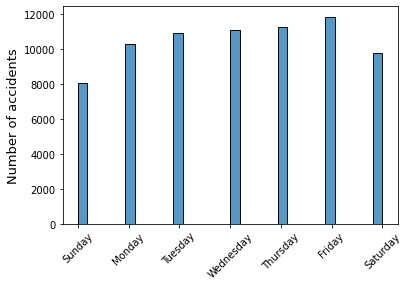

In [35]:
days = [0, 'Sunday', 'Monday', 'Tuesday',
        'Wednesday', 'Thursday', 'Friday', 'Saturday']

by_day = sns.histplot(data=accidents,
             x='day_of_week')
#by_day.set_xlabel("Day of the week", fontsize=13)
by_day.set_ylabel("Number of accidents", fontsize=13)
by_day.set_xlabel(" ")


by_day.set_xticklabels(days, rotation=45)
print(by_day.xaxis.get_ticklabels())

dow_fig = by_day.get_figure()
dow_fig.savefig(plots_dir / 'day_of_week', bbox_inches='tight')

In [24]:
accidents.day_of_week.value_counts()

6    11868
5    11252
4    11085
3    10939
2    10326
7     9775
1     8075
Name: day_of_week, dtype: int64

## Grouping by day of the week and time of day


In [4]:
def group_by_day(df, feature='accident_index', is_categorical=False, function='sum'):
    new_df = df.loc[:, ['day_of_week', feature]]
    if (is_categorical):
        one_hot = pd.get_dummies(new_df.loc[:, feature])
        new_df = pd.concat([new_df, one_hot], axis=1)
    grouped = new_df.groupby('day_of_week')
    if (function == 'sum'):
        return grouped.sum()
    elif (function == 'count'):
        return grouped.count()

def group_by_time(df, freq, feature='accident_index', is_categorical=False, function='sum'):
    new_df = df.loc[:, ['converted_time', feature]]
    date = str(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d').date())
    new_df['converted_time'] = pd.to_datetime(date + " " + new_df.converted_time.astype(str))
    if (is_categorical):
        one_hot = pd.get_dummies(new_df.loc[:, feature])
        new_df = pd.concat([new_df, one_hot], axis=1)
    grouped = new_df.groupby(pd.Grouper(key='converted_time', freq=freq))
    if (function == 'sum'):
        return grouped.sum()
    elif (function == 'count'):
        return grouped.count()

In [5]:
# merge the accidents and vehicles datasets
accidents_vehicles = pd.merge(accidents, vehicles, on='accident_index')
accidents_vehicles.columns

Index(['accident_index', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'local_authority_(district)',
       'local_authority_(highway)', '1st_road_class', '1st_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       '2nd_road_class', '2nd_road_number',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location', 'district', 'converted_date',
       'converted_time', 'sunrise', 'sunset', 'day_length', 'datetime',
       'decimal_time', 'day_of_year', 'vehicle_reference', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_location-restricted_lane',

### Grouping the aggregated accidents by day of the week

In [6]:
# grouping by the day of the week
accidents_by_day = group_by_day(accidents_vehicles, feature='accident_index', function='count')
accidents_by_day['zscore'] = stats.zscore(accidents_by_day['accident_index'])
accidents_by_day.columns = ['accident_count', 'z-score']

accidents_by_day

,accident_count,z-score
day_of_week,,
1,14859,-2.026469
2,18830,-0.160009
3,20025,0.401668
4,20392,0.574166
5,20633,0.687442
6,21727,1.201646
7,17727,-0.678444


## Grouping the accidents by day of the week by vehicle type

In [7]:
vehicle_by_day = group_by_day(accidents_vehicles, 'vehicle_type', True)
vehicle_by_day = vehicle_by_day.drop('vehicle_type', axis=1)

vehicle_type_ref = pd.read_csv(additional_data_dir / 'vehicle_type.csv')
labels = vehicle_type_ref.set_index('code').to_dict()['label']

vehicle_by_day

,-1,1,2,3,4,5,8,9,10,11,...,17,18,19,20,21,22,23,90,97,98
day_of_week,,,,,,,,,,,,,,,,,,,,,
1,16.0,1006.0,119.0,607.0,164.0,426.0,515.0,11066.0,31.0,211.0,...,16.0,2.0,449.0,24.0,54.0,13.0,8.0,60.0,38.0,22.0
2,23.0,1697.0,118.0,759.0,187.0,361.0,351.0,12942.0,42.0,478.0,...,39.0,5.0,1231.0,69.0,293.0,21.0,8.0,90.0,37.0,77.0
3,29.0,1919.0,140.0,804.0,217.0,402.0,456.0,13678.0,36.0,440.0,...,36.0,6.0,1217.0,93.0,314.0,19.0,5.0,90.0,38.0,80.0
4,17.0,1919.0,144.0,814.0,201.0,433.0,485.0,13959.0,48.0,466.0,...,31.0,2.0,1243.0,99.0,321.0,19.0,3.0,83.0,32.0,70.0
5,15.0,1911.0,130.0,839.0,231.0,420.0,513.0,14058.0,51.0,450.0,...,35.0,3.0,1281.0,99.0,363.0,20.0,7.0,92.0,52.0,60.0
6,22.0,1680.0,161.0,954.0,232.0,445.0,582.0,15156.0,41.0,515.0,...,27.0,2.0,1242.0,87.0,335.0,18.0,9.0,93.0,44.0,80.0
7,13.0,1154.0,122.0,688.0,172.0,428.0,621.0,13069.0,40.0,379.0,...,27.0,4.0,684.0,39.0,100.0,23.0,9.0,64.0,43.0,42.0


### Create a dictionary of form { vehicle_type: df(accident_stats) }

In [8]:
by_vehicle_day = {}

def type_by_day(vehicles_by_day, accidents_by_day):
    """
    Creates a dictionary of the form { vehicle_type: df(accident_stats) }
    for all vehicle_types present in the dataset aggregated on day of the week.
    """
    for col in vehicles_by_day.columns:
        vehicle_df = pd.DataFrame(vehicles_by_day.loc[:, col])
        vehicle_df['z-score'] = stats.zscore(vehicle_df)
        vehicle_df.columns = ['accident_count', 'z-score']
        vehicle_df['ratio'] = vehicle_df.accident_count / accidents_by_day.accident_count
        vehicle_df['day_of_week'] = vehicle_df.index
        by_vehicle_day[col] = vehicle_df
        
type_by_day(vehicle_by_day, accidents_by_day)

print(by_vehicle_day.keys())
by_vehicle_day[9] # index 9 == Car

dict_keys([-1, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98])


,accident_count,z-score,ratio,day_of_week
day_of_week,,,,
1,11066.0,-2.001280,0.744734,1
2,12942.0,-0.405215,0.687307,2
3,13678.0,0.220960,0.683046,3
4,13959.0,0.460029,0.684533,4
5,14058.0,0.544257,0.681336,5
6,15156.0,1.478414,0.697565,6
7,13069.0,-0.297166,0.737237,7


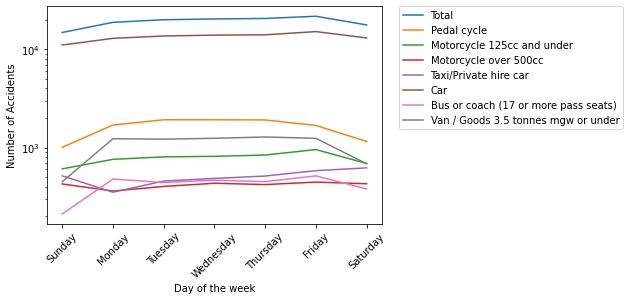

In [9]:
sns.lineplot(data=accidents_by_day, x='day_of_week', y='accident_count', label='Total')
for vehicle, data in by_vehicle_day.items():
    if data.ratio.mean() > 0.02:
        vehicle_day_plot = sns.lineplot(data=data, x='day_of_week', y='accident_count', label=labels[vehicle])
vehicle_day_plot.set_yscale('log')
vehicle_day_plot.set_xlabel("Day of the week")
vehicle_day_plot.set_ylabel("Number of Accidents")
vehicle_day_plot.set_xticks(range(1, 8), ['Sunday', 'Monday', 'Tuesday',
                                          'Wednesday', 'Thursday', 'Friday',
                                          'Saturday'],
                           rotation=45)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

vehicle_day_plot.figure.savefig(plots_dir / 'vehicle_day_plot', bbox_extra_artists=(lgd,), bbox_inches='tight')

## Total accidents by hour of the day


In [10]:
# grouping by time of day
accidents_by_hour = group_by_time(accidents_vehicles, freq='H', function='count')
accidents_by_hour['zscore'] = stats.zscore(accidents_by_hour['accident_index'])
accidents_by_hour.columns = ['accident_count', 'z-score']
accidents_by_hour

,accident_count,z-score
converted_time,,
2018-01-01 00:00:00,2133,-1.025686
2018-01-01 01:00:00,1449,-1.228547
2018-01-01 02:00:00,1106,-1.330274
2018-01-01 03:00:00,866,-1.401453
2018-01-01 04:00:00,878,-1.397894
2018-01-01 05:00:00,1254,-1.286380
2018-01-01 06:00:00,2555,-0.900529
2018-01-01 07:00:00,6175,0.173092
2018-01-01 08:00:00,9029,1.019532


## Grouping the accidents by hour of the day by vehicle

In [11]:
vehicle_by_hour= group_by_time(accidents_vehicles, 'H', 'vehicle_type', True)
vehicle_by_hour = vehicle_by_hour.drop('vehicle_type', axis=1)

vehicle_by_hour

,-1,1,2,3,4,5,8,9,10,11,...,17,18,19,20,21,22,23,90,97,98
converted_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,2.0,83.0,17.0,77.0,17.0,26.0,166.0,1578.0,8.0,33.0,...,5.0,0.0,67.0,6.0,24.0,1.0,0.0,11.0,4.0,8.0
2018-01-01 01:00:00,2.0,37.0,4.0,48.0,11.0,11.0,123.0,1107.0,6.0,15.0,...,0.0,0.0,58.0,5.0,13.0,0.0,1.0,4.0,2.0,2.0
2018-01-01 02:00:00,1.0,31.0,8.0,37.0,7.0,10.0,101.0,821.0,1.0,12.0,...,0.0,0.0,43.0,4.0,20.0,0.0,0.0,5.0,0.0,5.0
2018-01-01 03:00:00,1.0,23.0,1.0,20.0,3.0,6.0,91.0,649.0,2.0,11.0,...,1.0,0.0,31.0,1.0,18.0,0.0,0.0,4.0,2.0,2.0
2018-01-01 04:00:00,1.0,30.0,7.0,29.0,4.0,4.0,61.0,651.0,2.0,11.0,...,1.0,0.0,41.0,4.0,21.0,0.0,0.0,6.0,0.0,5.0
2018-01-01 05:00:00,0.0,103.0,8.0,45.0,10.0,17.0,66.0,829.0,1.0,19.0,...,3.0,0.0,91.0,8.0,38.0,1.0,0.0,4.0,2.0,9.0
2018-01-01 06:00:00,1.0,293.0,14.0,100.0,27.0,63.0,64.0,1640.0,3.0,35.0,...,2.0,0.0,200.0,20.0,62.0,1.0,1.0,18.0,4.0,7.0
2018-01-01 07:00:00,4.0,801.0,29.0,243.0,69.0,163.0,102.0,3916.0,10.0,94.0,...,9.0,1.0,513.0,28.0,129.0,1.0,4.0,27.0,5.0,27.0
2018-01-01 08:00:00,16.0,1179.0,39.0,272.0,103.0,179.0,165.0,6008.0,23.0,157.0,...,11.0,1.0,607.0,39.0,147.0,8.0,5.0,31.0,9.0,29.0


### Create a dictionary of form { vehicle_type: df(accident_stats) }

In [12]:
by_vehicle_hour = {}

def type_by_hour(vehicles_by_hour, accidents_by_hour):
    """
    Creates a dictionary of the form { vehicle_type: df(accident_stats) }
    for all vehicle_types present in the dataset aggregated on the hour of the day.
    """
    for col in vehicles_by_hour.columns:
        vehicle_df = pd.DataFrame(vehicles_by_hour.loc[:, col])
        vehicle_df['z-score'] = stats.zscore(vehicle_df)
        vehicle_df.columns = ['accident_count', 'z-score']
        vehicle_df['ratio'] = vehicle_df.accident_count / accidents_by_hour.accident_count
        by_vehicle_hour[col] = vehicle_df
        
type_by_hour(vehicle_by_hour, accidents_by_hour)

by_vehicle_hour[9] # 9 == Car

,accident_count,z-score,ratio
converted_time,,,
2018-01-01 00:00:00,1578.0,-0.998432,0.739803
2018-01-01 01:00:00,1107.0,-1.199771,0.763975
2018-01-01 02:00:00,821.0,-1.322028,0.742315
2018-01-01 03:00:00,649.0,-1.395554,0.749423
2018-01-01 04:00:00,651.0,-1.394699,0.741458
2018-01-01 05:00:00,829.0,-1.318609,0.661085
2018-01-01 06:00:00,1640.0,-0.971929,0.641879
2018-01-01 07:00:00,3916.0,0.000997,0.634170
2018-01-01 08:00:00,6008.0,0.895269,0.665411


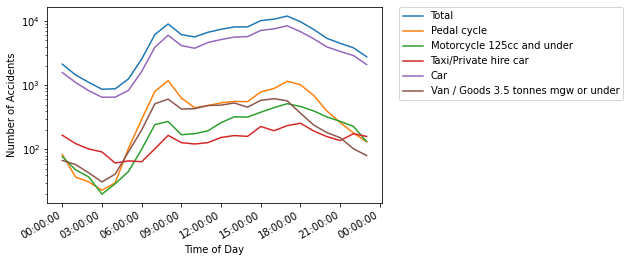

In [13]:
vehicle_hour_plot = sns.lineplot(data=accidents_by_hour, x='converted_time', y='accident_count', label='Total')
for vehicle, data in by_vehicle_hour.items():
    if data.ratio.mean() > 0.02:
        vehicle_hour_plot = sns.lineplot(data=data, x='converted_time', y='accident_count', label=labels[vehicle])
vehicle_hour_plot.set_yscale('log')
vehicle_hour_plot.set_xlabel("Time of Day")
vehicle_hour_plot.set_ylabel("Number of Accidents")

hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%H:%M:%S')


vehicle_hour_plot.xaxis.set_major_locator(hours)
vehicle_hour_plot.xaxis.set_major_formatter(h_fmt)

vehicle_hour_plot.figure.autofmt_xdate()

lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

vehicle_hour_plot.figure.savefig(plots_dir / 'vehicle_hour_plot', bbox_extra_artists=(lgd,), bbox_inches='tight')

### Does the point of impact affect accident intensity?

In [14]:
accidents.head(5)

,accident_index,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_(district),local_authority_(highway),...,lsoa_of_accident_location,district,converted_date,converted_time,sunrise,sunset,day_length,datetime,decimal_time,day_of_year
0,2019010152270,-0.127949,51.436208,1,3,2,1,3,9,E09000022,...,E01003117,lambeth,2019-01-15,21:45:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 21:45:00,21.750000,15
1,2019010157567,-0.123427,51.449310,1,3,2,2,3,9,E09000022,...,E01003023,lambeth,2019-01-15,08:42:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 08:42:00,8.700000,15
2,2019010157732,-0.145106,51.461256,1,2,1,2,3,9,E09000022,...,E01003026,lambeth,2019-01-15,07:08:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 07:08:00,7.133333,15
3,2019010157896,-0.240823,51.533125,1,3,2,1,3,28,E09000005,...,E01000535,brent,2019-01-15,21:05:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 21:05:00,21.083333,15
4,2019010157795,0.161736,51.550272,1,3,1,1,3,16,E09000002,...,E01000035,barking and dagenham,2019-01-15,16:10:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 16:10:00,16.166667,15


In [15]:
vehicles.columns

Index(['accident_index', 'vehicle_reference', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_location-restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
       'vehicle_leaving_carriageway', 'hit_object_off_carriageway',
       '1st_point_of_impact', 'was_vehicle_left_hand_drive?',
       'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'age_band_of_driver', 'engine_capacity_(cc)', 'propulsion_code',
       'age_of_vehicle', 'driver_imd_decile', 'driver_home_area_type',
       'vehicle_imd_decile'],
      dtype='object')

In [16]:
impact = pd.merge(vehicles.filter(['accident_index', '1st_point_of_impact']), accidents.filter(['accident_index', 'accident_severity']), on='accident_index')
impact = impact[impact['1st_point_of_impact'] >= 0]
impact = impact.drop('accident_index', axis=1)

data = impact.to_numpy().T
stats.contingency.association(data, method='cramer')

0.3133637421984567

## Checking casualty types

In [17]:
casualty_types = pd.merge(casualties.filter(['accident_index', 'casualty_type']), accidents.filter(['accident_index', 'accident_severity']), on='accident_index')
casualty_types = casualty_types[casualty_types['casualty_type'] >= 0]
casualty_types = casualty_types.drop('accident_index', axis=1)

data = casualty_types.to_numpy().T
stats.contingency.association(data, method='cramer')

0.45087385703957045